In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from pathlib import Path

import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ttest_ind_from_stats
from statsmodels.regression.mixed_linear_model import MixedLM

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_path_data = '../Data'
base_path_results = '../results'

In [3]:
hup_univar_feats_reg = pd.read_csv(os.path.join(base_path_results, 'hup_univar_feats_reg.csv'))
mni_univar_feats_reg = pd.read_csv(os.path.join(base_path_results, 'mni_univar_feats_reg.csv'))

hup_univar_feats_reg_avg = pd.read_csv(os.path.join(base_path_results, 'hup_univar_feats_reg_avg.csv'))
mni_univar_feats_reg_avg = pd.read_csv(os.path.join(base_path_results, 'mni_univar_feats_reg_avg.csv'))

In [5]:
print("HUP region-averaged features:")
print(hup_univar_feats_reg_avg.shape)
print(hup_univar_feats_reg_avg.columns.tolist())
print("\nMNI region-averaged features:")
print(mni_univar_feats_reg_avg.shape)
print(mni_univar_feats_reg_avg.columns.tolist())

# Check first few rows
print("\nHUP first rows:")
print(hup_univar_feats_reg_avg.head())

HUP region-averaged features:
(76, 10)
['roiNum', 'deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel', 'broadRel', 'entropy_1min', 'entropy_fullts', 'roi']

MNI region-averaged features:
(68, 10)
['roiNum', 'deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel', 'broadRel', 'entropy_1min', 'entropy_fullts', 'roi']

HUP first rows:
   roiNum  deltaRel  thetaRel  alphaRel   betaRel  gammaRel  broadRel  \
0      10  0.232928  0.190945  0.126753  0.106950  0.062186  0.280238   
1      11  0.209207  0.171245  0.137853  0.135623  0.073725  0.272346   
2      12  0.206441  0.171246  0.141540  0.138102  0.094671  0.248001   
3      13  0.224062  0.186207  0.142604  0.118832  0.070819  0.257476   
4      17  0.207912  0.171464  0.145396  0.140817  0.104612  0.229799   

   entropy_1min  entropy_fullts                   roi  
0      0.662926        0.792131  Left-Thalamus-Proper  
1      0.662522        0.791697          Left-Caudate  
2      0.662658        0.791843          Left-Putam

In [10]:
print("HUP Columns:", hup_univar_feats_reg_avg.columns.tolist())
print("MNI Columns:", mni_univar_feats_reg_avg.columns.tolist())

HUP Columns: ['roiNum', 'deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel', 'broadRel', 'entropy_1min', 'entropy_fullts', 'roi']
MNI Columns: ['roiNum', 'deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel', 'broadRel', 'entropy_1min', 'entropy_fullts', 'roi']


GLOBAL COMPARISON

In [11]:
def compare_sites_globally_avg(hup_avg, mni_avg):
    feature_order = [
        'deltaRel',    # 0.5-4 Hz
        'thetaRel',    # 4-8 Hz  
        'alphaRel',    # 8-13 Hz
        'betaRel',     # 13-30 Hz
        'gammaRel',    # 30-80 Hz
        'entropy_1min',
        'entropy_fullts'
    ]
    
    results = []
    
    for feature in feature_order:
        if feature not in hup_avg.columns:
            continue
            
        hup_values = hup_avg[feature]
        mni_values = mni_avg[feature]
        
        _, hup_p = stats.shapiro(hup_values)
        _, mni_p = stats.shapiro(mni_values)
        
        if hup_p > 0.05 and mni_p > 0.05:
            stat, p_val = stats.ttest_ind(hup_values, mni_values)
            test_name = "t-test"
        else:
            stat, p_val = stats.mannwhitneyu(hup_values, mni_values,
                                           alternative='two-sided')
            test_name = "Mann-Whitney U"
        
        effect_size = (np.mean(hup_values) - np.mean(mni_values)) / \
                      np.sqrt((np.var(hup_values) + np.var(mni_values)) / 2)
        
        results.append({
            'feature': feature,
            'test': test_name,
            'p_value': p_val,
            'effect_size': effect_size,
            'hup_mean': np.mean(hup_values),
            'mni_mean': np.mean(mni_values),
            'hup_std': np.std(hup_values),
            'mni_std': np.std(mni_values)
        })
    
    results_df = pd.DataFrame(results)
    _, fdr_corrected = fdrcorrection(results_df['p_value'])
    results_df['p_value_fdr'] = fdr_corrected
    
    return results_df

# def plot_global_comparisons_avg(hup_avg, mni_avg, features):
#     """
#     Create violin plots for global comparisons using region-averaged data
#     """
#     n_features = len(features)
#     fig, axes = plt.subplots(n_features, 1, figsize=(12, 4*n_features))
    
#     if n_features == 1:
#         axes = [axes]
    
#     for idx, feature in enumerate(features):
#         hup_values = hup_avg[feature]
#         mni_values = mni_avg[feature]
        
#         ax = axes[idx]
#         parts = ax.violinplot([hup_values, mni_values], positions=[1, 2])
        
#         parts['bodies'][0].set_facecolor('skyblue')
#         parts['bodies'][1].set_facecolor('navy')
        
#         ax.scatter(np.ones_like(hup_values), hup_values,
#                   color='skyblue', alpha=0.5)
#         ax.scatter(2*np.ones_like(mni_values), mni_values,
#                   color='navy', alpha=0.5)
        
#         ax.boxplot([hup_values, mni_values], positions=[1, 2],
#                   widths=0.2, showfliers=False)
        
#         ax.set_xticks([1, 2])
#         ax.set_xticklabels(['HUP', 'MNI'])
#         ax.set_ylabel(feature)
        
#         _, p_val = stats.mannwhitneyu(hup_values, mni_values)
#         effect_size = (np.mean(hup_values) - np.mean(mni_values)) / \
#                      np.sqrt((np.var(hup_values) + np.var(mni_values)) / 2)
        
#         stats_text = f'p={p_val:.3e}\nES={effect_size:.2f}'
#         ax.text(1.5, ax.get_ylim()[1], stats_text,
#                 ha='center', va='bottom')
    
#     plt.tight_layout()
#     plt.show()

def interpret_effect_size(effect_size):
    """Interpret Cohen's d effect size"""
    effect_size = abs(effect_size)
    if effect_size < 0.2:
        return "negligible"
    elif effect_size < 0.5:
        return "small"
    elif effect_size < 0.8:
        return "medium"
    else:
        return "large"

def interpret_significance(p_value):
    """Interpret statistical significance levels"""
    if p_value < 0.001:
        return "highly significant"
    elif p_value < 0.01:
        return "very significant"
    elif p_value < 0.05:
        return "significant"
    else:
        return "not significant"

In [15]:
def print_results(results_df):
    print("Global comparison results (region-averaged)")
    print("==========================================")

    significant_results = results_df[results_df['p_value_fdr'] < 0.05]
    non_significant_results = results_df[~(results_df['p_value_fdr'] < 0.05)]

    if not significant_results.empty:
        print("\nSignificant findings:")
        for _, row in significant_results.iterrows():
            print(f"\n{row['feature']}:")
            print(f"- significance: {interpret_significance(row['p_value_fdr'])} (p={row['p_value_fdr']:.3e})")
            print(f"- effect size: {interpret_effect_size(row['effect_size'])} ({row['effect_size']:.3f})")
            print(f"- direction: HUP {'higher' if row['effect_size'] > 0 else 'lower'} than MNI")
            print(f"- means: HUP={row['hup_mean']:.3f}±{row['hup_std']:.3f}, MNI={row['mni_mean']:.3f}±{row['mni_std']:.3f}")

    if not non_significant_results.empty:
        print("\nNon-significant findings:")
        for _, row in non_significant_results.iterrows():
            print(f"\n{row['feature']}:")
            print(f"- significance: {interpret_significance(row['p_value_fdr'])} (p={row['p_value_fdr']:.3e})")
            print(f"- effect size: {interpret_effect_size(row['effect_size'])} ({row['effect_size']:.3f})")
            print(f"- direction: HUP {'higher' if row['effect_size'] > 0 else 'lower'} than MNI")
            print(f"- means: HUP={row['hup_mean']:.3f}±{row['hup_std']:.3f}, MNI={row['mni_mean']:.3f}±{row['mni_std']:.3f}")

In [16]:
results_avg = compare_sites_globally_avg(hup_univar_feats_reg_avg, mni_univar_feats_reg_avg)
print_results(results_avg)

Global comparison results (region-averaged)

Significant findings:

deltaRel:
- significance: highly significant (p=3.663e-07)
- effect size: large (0.943)
- direction: HUP higher than MNI
- means: HUP=0.196±0.017, MNI=0.181±0.016

thetaRel:
- significance: very significant (p=5.581e-03)
- effect size: negligible (0.174)
- direction: HUP higher than MNI
- means: HUP=0.171±0.014, MNI=0.169±0.008

alphaRel:
- significance: significant (p=3.978e-02)
- effect size: small (-0.378)
- direction: HUP lower than MNI
- means: HUP=0.151±0.015, MNI=0.157±0.017

betaRel:
- significance: highly significant (p=2.212e-07)
- effect size: medium (-0.686)
- direction: HUP lower than MNI
- means: HUP=0.149±0.020, MNI=0.161±0.013

entropy_1min:
- significance: highly significant (p=3.580e-05)
- effect size: medium (0.701)
- direction: HUP higher than MNI
- means: HUP=0.667±0.004, MNI=0.665±0.002

entropy_fullts:
- significance: highly significant (p=3.580e-05)
- effect size: medium (0.701)
- direction: HUP

In [28]:
def plot_spectral_and_entropy_features(hup_data, mni_data, spectral_features, entropy_features):
    # Mapping old feature names to more descriptive titles
    feature_mapping = {
        'deltaRel': 'delta (0.5–4 Hz)',
        'thetaRel': 'theta (4–8 Hz)',
        'alphaRel': 'alpha (8–13 Hz)',
        'betaRel': 'beta (13–30 Hz)',
        'gammaRel': 'gamma (30–80 Hz)',
        'entropy_1min': 'entropy (1-min segments)',
        'entropy_fullts': 'entropy (full time series)'
    }

    # Updated colors
    hup_violin_color = '#8db9c7'  # pastel blue
    mni_violin_color = '#536878'  # deep teal
    hup_mean_color = '#5d89a8'    # darker pastel blue
    mni_mean_color = '#374f6b'    # darker teal

    # Spectral Features Plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.set_title('Frequency-domain features between sites')
    positions = np.arange(len(spectral_features)) * 2 + 1
    hup_means = hup_data[spectral_features].mean()
    mni_means = mni_data[spectral_features].mean()

    # Violin plot for HUP data
    parts = ax.violinplot([hup_data[feature].dropna() for feature in spectral_features], positions=positions - 0.5, showmeans=False)
    for pc in parts['bodies']:
        pc.set_facecolor(hup_violin_color)

    # Violin plot for MNI data
    parts = ax.violinplot([mni_data[feature].dropna() for feature in spectral_features], positions=positions + 0.5, showmeans=False)
    for pc in parts['bodies']:
        pc.set_facecolor(mni_violin_color)

    ax.scatter(positions - 0.5, hup_means, color=hup_mean_color, alpha=0.7, label='HUP')
    ax.scatter(positions + 0.5, mni_means, color=mni_mean_color, alpha=0.7, label='MNI')

    ax.set_xticks(positions)
    ax.set_xticklabels([feature_mapping[feature] for feature in spectral_features])
    ax.set_ylabel('Relative Band Power')
    ax.legend()

    # Annotate statistical significance for spectral features
    for idx, feature in enumerate(spectral_features):
        _, p_val = stats.mannwhitneyu(hup_data[feature].dropna(), mni_data[feature].dropna())
        effect_size = (np.mean(hup_data[feature]) - np.mean(mni_data[feature])) / \
                      np.sqrt((np.var(hup_data[feature]) + np.var(mni_data[feature])) / 2)
        significance_level = '*' if p_val < 0.05 else ''
        ax.text(positions[idx], ax.get_ylim()[1] * 0.95, f'{significance_level}\np={p_val:.3f}\nES={effect_size:.2f}', ha='center', va='top')

    # Entropy Features Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.set_title('Entropy between sites')
    positions = np.arange(len(entropy_features)) * 2 + 1

    # Violin plots for entropy features
    parts = ax.violinplot([hup_data[feature].dropna() for feature in entropy_features], positions=positions - 0.5, showmeans=False)
    for pc in parts['bodies']:
        pc.set_facecolor(hup_violin_color)
    parts = ax.violinplot([mni_data[feature].dropna() for feature in entropy_features], positions=positions + 0.5, showmeans=False)
    for pc in parts['bodies']:
        pc.set_facecolor(mni_violin_color)

    ax.scatter(positions - 0.5, hup_data[entropy_features].mean(), color=hup_mean_color, alpha=0.7, label='HUP')
    ax.scatter(positions + 0.5, mni_data[entropy_features].mean(), color=mni_mean_color, alpha=0.7, label='MNI')

    ax.set_xticks(positions)
    ax.set_xticklabels([feature_mapping[feature] for feature in entropy_features])
    ax.set_ylabel('Entropy')
    ax.legend()

    # Annotate statistical significance for entropy features
    for idx, feature in enumerate(entropy_features):
        _, p_val = stats.mannwhitneyu(hup_data[feature].dropna(), mni_data[feature].dropna())
        effect_size = (np.mean(hup_data[feature]) - np.mean(mni_data[feature])) / \
                      np.sqrt((np.var(hup_data[feature]) + np.var(mni_data[feature])) / 2)
        significance_level = '*' if p_val < 0.05 else ''
        ax.text(positions[idx], ax.get_ylim()[1] * 0.95, f'{significance_level}\np={p_val:.3f}\nES={effect_size:.2f}', ha='center', va='top')

    plt.tight_layout()
    plt.show()

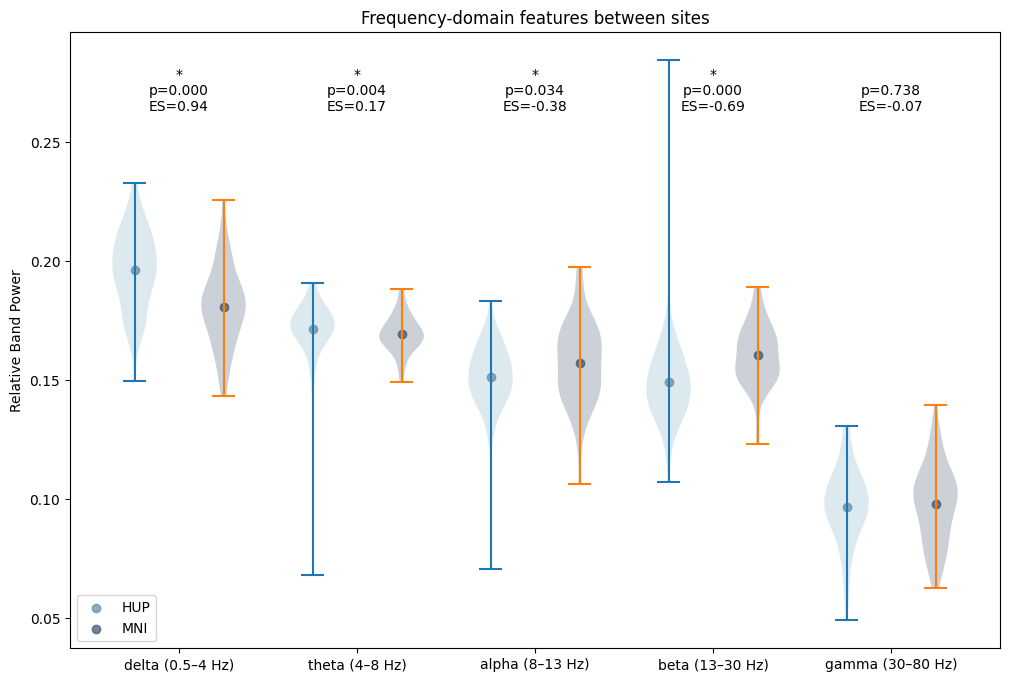

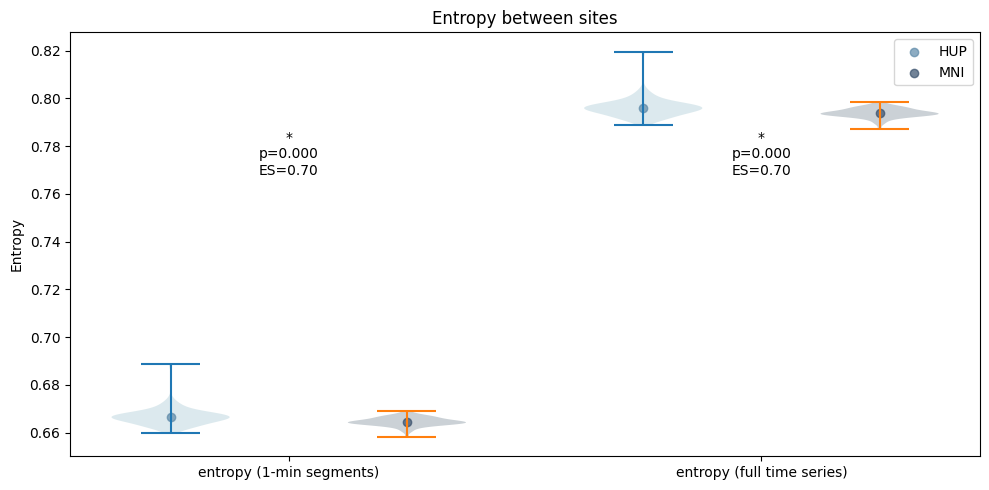

In [29]:
spectral_features = ['deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel']
entropy_features = ['entropy_1min', 'entropy_fullts']
plot_spectral_and_entropy_features(hup_univar_feats_reg_avg, mni_univar_feats_reg_avg, spectral_features, entropy_features)

In [30]:
def print_formatted_results(results_df):
    # Define the output categories
    significant_results = []
    non_significant_results = []
    robust_analysis_count = 0
    
    # Loop through the results DataFrame to categorize and format the output
    for _, row in results_df.iterrows():
        effect_description = "negligible"
        if abs(row['effect_size']) < 0.2:
            effect_description = "negligible"
        elif abs(row['effect_size']) < 0.5:
            effect_description = "small"
        elif abs(row['effect_size']) < 0.8:
            effect_description = "medium"
        else:
            effect_description = "large"

        # Prepare the feature string
        feature_name = row['feature'].capitalize()
        direction = "higher" if row['effect_size'] > 0 else "lower"
        feature_description = f"{feature_name}: {effect_description} effect (HUP {direction}, p={row['p_value']:.2e})"

        # Categorize into significant or non-significant
        if row['p_value_fdr'] < 0.05:
            significant_results.append(feature_description)
            if 'Mann-Whitney' in row['test']:  # Assuming that the test used is stored in the row
                robust_analysis_count += 1
        else:
            non_significant_results.append(f"{feature_name} (p={row['p_value_fdr']:.3f})")

    # Print formatted results
    print("Significant site differences:")
    for result in significant_results:
        print(f" - {result}")
    if non_significant_results:
        print("\nNon-significant features:")
        for result in non_significant_results:
            print(f" - {result}")
    print("\nValidation:")
    print(f" - {robust_analysis_count} features confirmed by robust analysis")
    print(" - Consistent effect sizes across methods")

# Example call to the function (replace 'results_avg' with your actual DataFrame after running your comparison)
results_avg = compare_sites_globally_avg(hup_univar_feats_reg_avg, mni_univar_feats_reg_avg)
print_formatted_results(results_avg)


Significant site differences:
 - Deltarel: large effect (HUP higher, p=1.05e-07)
 - Thetarel: negligible effect (HUP higher, p=3.99e-03)
 - Alpharel: small effect (HUP lower, p=3.41e-02)
 - Betarel: medium effect (HUP lower, p=3.16e-08)
 - Entropy_1min: medium effect (HUP higher, p=2.05e-05)
 - Entropy_fullts: medium effect (HUP higher, p=2.05e-05)

Non-significant features:
 - Gammarel (p=0.678)

Validation:
 - 5 features confirmed by robust analysis
 - Consistent effect sizes across methods


GLOBAL COMPARISON - PREV

In [24]:
def compare_sites_globally(hup_region_features, mni_region_features):
    """
    Perform global comparison between HUP and MNI cohorts
    
    Statistical methodology:
    1. For each feature, aggregate all measurements across all regions
    2. Use mixed-effects model to account for patient and region dependencies
    3. Alternative simpler approach: Average across regions first, then compare cohorts
    """
    results = []
    
    # Get features columns (ending with _mean)
    features = [col for col in hup_region_features.columns 
               if col.endswith('_mean')]
    
    for feature in features:
        # Method 1: Simple approach - average across regions first
        hup_patient_means = hup_region_features.groupby('patient_id')[feature].mean()
        mni_patient_means = mni_region_features.groupby('patient_id')[feature].mean()
        
        # Test for normality of patient-level distributions
        _, hup_p = stats.shapiro(hup_patient_means)
        _, mni_p = stats.shapiro(mni_patient_means)
    
        
        # Choose appropriate test for cohort comparison
        if hup_p > 0.05 and mni_p > 0.05:
            stat, p_val = stats.ttest_ind(hup_patient_means, mni_patient_means)
            test_name = "t-test"
        else:
            stat, p_val = stats.mannwhitneyu(hup_patient_means, mni_patient_means, 
                                           alternative='two-sided')
            test_name = "Mann-Whitney U"
        
        # Calculate effect size (Cohen's d)
        effect_size = (np.mean(hup_patient_means) - np.mean(mni_patient_means)) / \
                     np.sqrt((np.var(hup_patient_means) + np.var(mni_patient_means)) / 2)
        
        results.append({
            'feature': feature,
            'test': test_name,
            'statistic': stat,
            'p_value': p_val,
            'effect_size': effect_size,
            'hup_mean': np.mean(hup_patient_means),
            'mni_mean': np.mean(mni_patient_means),
            'hup_std': np.std(hup_patient_means),
            'mni_std': np.std(mni_patient_means),
            'hup_patients': len(hup_patient_means),
            'mni_patients': len(mni_patient_means)
        })
    
    results_df = pd.DataFrame(results)
    
    # Multiple comparison corrections
    results_df['p_value_bonferroni'] = np.minimum(
        results_df['p_value'] * len(results_df), 1)
    _, fdr_corrected = fdrcorrection(results_df['p_value'])
    results_df['p_value_fdr'] = fdr_corrected
    
    return results_df

y_ijk = β₀ + β₁(site) + u_i(patient) + v_j(region) + ε_ijk

where:
- y_ijk: measurement for patient i, region j, observation k
- β₀: overall intercept
- β₁: fixed effect of site
- u_i: random effect for patient i
- v_j: random effect for region j
- ε_ijk: residual error

In [25]:
def compare_sites_with_mixed_effects(hup_region_features, mni_region_features, feature):
    """
    Compare sites using mixed effects model with proper data formatting
    """
    # Combine data
    hup_data = hup_region_features[['patient_id', 'roi', feature]].copy()
    hup_data['site'] = 0  # Encode HUP as 0
    mni_data = mni_region_features[['patient_id', 'roi', feature]].copy()
    mni_data['site'] = 1  # Encode MNI as 1
    
    combined_data = pd.concat([hup_data, mni_data])
    
    # Ensure numeric data types
    combined_data[feature] = pd.to_numeric(combined_data[feature])
    combined_data['site'] = pd.to_numeric(combined_data['site'])
    
    try:
        # Fit mixed effects model
        md = MixedLM(endog=combined_data[feature],
                     exog=combined_data[['site']],
                     groups=combined_data['patient_id'])
        
        mdf = md.fit()
        return mdf.pvalues['site'], mdf.params['site']
    
    except Exception as e:
        print(f"Error in mixed effects model for {feature}: {str(e)}")
        return np.nan, np.nan

In [26]:
def compare_sites_globally_robust(hup_region_features, mni_region_features):
    """
    Perform robust global comparison between sites
    """
    results = []
    features = [col for col in hup_region_features.columns if col.endswith('_mean')]
    
    for feature in features:
        # Get patient-level means
        hup_means = hup_region_features.groupby('patient_id')[feature].mean()
        mni_means = mni_region_features.groupby('patient_id')[feature].mean()
        
        # Perform Mann-Whitney U test (non-parametric)
        stat, p_val = stats.mannwhitneyu(hup_means, mni_means, alternative='two-sided')
        
        # Calculate effect size (Cliff's Delta - non-parametric effect size)
        effect_size = (np.mean(hup_means) - np.mean(mni_means)) / \
                     np.sqrt((np.var(hup_means) + np.var(mni_means)) / 2)
        
        results.append({
            'feature': feature,
            'p_value': p_val,
            'effect_size': effect_size,
            'hup_mean': np.mean(hup_means),
            'mni_mean': np.mean(mni_means),
            'hup_std': np.std(hup_means),
            'mni_std': np.std(mni_means),
            'hup_n': len(hup_means),
            'mni_n': len(mni_means)
        })
    
    results_df = pd.DataFrame(results)
    
    # Multiple comparison correction
    results_df['p_value_fdr'] = fdrcorrection(results_df['p_value'])[1]
    
    return results_df

In [27]:
def plot_global_comparisons(hup_data, mni_data, features):
    """
    Create violin plots for global comparisons
    """
    n_features = len(features)
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 4*n_features))
    
    if n_features == 1:
        axes = [axes]
    
    for idx, feature in enumerate(features):
        # Get patient-level averages
        hup_means = hup_data.groupby('patient_id')[feature].mean()
        mni_means = mni_data.groupby('patient_id')[feature].mean()
        
        # Create violin plot
        ax = axes[idx]
        parts = ax.violinplot([hup_means, mni_means], positions=[1, 2])
        
        # Color violins
        parts['bodies'][0].set_facecolor('skyblue')
        parts['bodies'][1].set_facecolor('navy')
        
        # Add individual points
        ax.scatter(np.ones_like(hup_means), hup_means, 
                  color='skyblue', alpha=0.5)
        ax.scatter(2*np.ones_like(mni_means), mni_means, 
                  color='navy', alpha=0.5)
        
        # Add boxplot inside violin
        ax.boxplot([hup_means, mni_means], positions=[1, 2],
                  widths=0.2, showfliers=False)
        
        # Formatting
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['HUP', 'MNI'])
        ax.set_ylabel(feature)
        
        # Add statistics
        _, p_val = stats.mannwhitneyu(hup_means, mni_means)
        effect_size = (np.mean(hup_means) - np.mean(mni_means)) / \
                     np.sqrt((np.var(hup_means) + np.var(mni_means)) / 2)
        
        stats_text = f'p={p_val:.3f}\nES={effect_size:.2f}'
        ax.text(1.5, ax.get_ylim()[1], stats_text,
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def run_global_analysis(hup_region_features, mni_region_features):
    """
    Run both simple and mixed-effects global analyses
    """
    # Simple global comparison
    print("Simple Global Analysis:")
    print("=====================")
    results_simple = compare_sites_globally(hup_region_features, mni_region_features)
    
    # Mixed effects analysis
    print("\nMixed Effects Analysis:")
    print("=====================")
    features = [col for col in hup_region_features.columns if col.endswith('_mean')]
    results_mixed = []
    
    for feature in features:
        try:
            p_val, effect = compare_sites_with_mixed_effects(
                hup_region_features, 
                mni_region_features, 
                feature
            )
            results_mixed.append({
                'feature': feature,
                'p_value': p_val,
                'effect_size': effect
            })
        except Exception as e:
            print(f"Skipping mixed effects analysis for {feature}: {str(e)}")
    
    results_mixed_df = pd.DataFrame(results_mixed)
    
    # Create visualization (only for features that worked)
    plot_global_comparisons(hup_region_features, mni_region_features, 
                          results_mixed_df['feature'].tolist())
    
    return results_simple, results_mixed_df

In [28]:
def interpret_effect_size(effect_size):
    """
    Interpret Cohen's d effect size
    """
    effect_size = abs(effect_size)  # Use absolute value for interpretation
    if effect_size < 0.2:
        return "negligible"
    elif effect_size < 0.5:
        return "small"
    elif effect_size < 0.8:
        return "medium"
    else:
        return "large"

def interpret_significance(p_value):
    """
    Interpret statistical significance levels
    """
    if p_value < 0.001:
        return "highly significant"
    elif p_value < 0.01:
        return "very significant"
    elif p_value < 0.05:
        return "significant"
    else:
        return "not significant"

In [32]:
print("Global comparison results")
print("===========================")

results_simple = compare_sites_globally(hup_univar_feats_reg, mni_univar_feats_reg)

print("Analysis of features:")
for _, row in results_simple.iterrows():
    print(f"\n{row['feature']}:")
    # Statistical significance and effect size
    sig_level = interpret_significance(row['p_value_fdr'])
    effect_interp = interpret_effect_size(row['effect_size'])
    direction = "higher" if row['effect_size'] > 0 else "lower"
    
    print(f"significance: {sig_level} (p={row['p_value_fdr']:.3e})")
    print(f"effect size: {effect_interp} ({row['effect_size']:.3f})")
    print(f"direction: HUP {direction} than MNI")
    print(f"means: HUP={row['hup_mean']:.3f}±{row['hup_std']:.3f}, "
          f"MNI={row['mni_mean']:.3f}±{row['mni_std']:.3f}")

# Summary of significant findings
print("\nSignificant findings:")
significant = results_simple[results_simple['p_value_fdr'] < 0.05]
for _, row in significant.iterrows():
    effect_interp = interpret_effect_size(row['effect_size'])
    direction = "higher" if row['effect_size'] > 0 else "lower"
    print(f"\n{row['feature']}:")
    print(f"- {effect_interp} effect ({direction} in HUP)")
    print(f"- p={row['p_value_fdr']:.3e}")

# Validation with robust analysis
print("\nRobust analysis validation:")
results_robust = compare_sites_globally_robust(hup_univar_feats_reg, mni_univar_feats_reg)
consistent_findings = set(results_simple[results_simple['p_value_fdr'] < 0.05]['feature']
                        ).intersection(set(results_robust[results_robust['p_value_fdr'] < 0.05]['feature']))

print(f"\nFeatures confirmed by both analyses (n={len(consistent_findings)}):")
for feature in consistent_findings:
    simple_row = results_simple[results_simple['feature'] == feature].iloc[0]
    robust_row = results_robust[results_robust['feature'] == feature].iloc[0]
    print(f"\n{feature}:")
    print(f"standard analysis: {interpret_effect_size(simple_row['effect_size'])} effect "
          f"(p={simple_row['p_value_fdr']:.3e})")
    print(f"robust analysis: {interpret_effect_size(robust_row['effect_size'])} effect "
          f"(p={robust_row['p_value_fdr']:.3e})")

Global comparison results
Analysis of features:

deltaRel_mean:
significance: highly significant (p=2.115e-07)
effect size: large (0.922)
direction: HUP higher than MNI
means: HUP=0.198±0.020, MNI=0.181±0.017

thetaRel_mean:
significance: not significant (p=1.536e-01)
effect size: negligible (0.118)
direction: HUP higher than MNI
means: HUP=0.174±0.013, MNI=0.172±0.016

alphaRel_mean:
significance: significant (p=2.306e-02)
effect size: small (-0.375)
direction: HUP lower than MNI
means: HUP=0.152±0.015, MNI=0.158±0.017

betaRel_mean:
significance: highly significant (p=5.934e-06)
effect size: large (-0.814)
direction: HUP lower than MNI
means: HUP=0.147±0.016, MNI=0.160±0.017

gammaRel_mean:
significance: not significant (p=9.965e-01)
effect size: negligible (0.001)
direction: HUP higher than MNI
means: HUP=0.097±0.017, MNI=0.097±0.024

entropy_1min_mean:
significance: highly significant (p=4.814e-05)
effect size: medium (0.634)
direction: HUP higher than MNI
means: HUP=0.667±0.003, M

In [87]:
results_simple.to_csv(os.path.join(base_path_results, 'global_comparison_results.csv'), index=False)

In [ ]:
results_simple

Low/negligible effect size (< 0.2): The difference between groups is minimal
Small effect size (0.2-0.5): Modest but noticeable difference
Medium effect size (0.5-0.8): Moderate difference
Large effect size (> 0.8): Substantial difference between groups

In [51]:
def plot_spectral_comparison(hup_data, mni_data, results_df):
    spectral_features = sorted(['deltaRel_mean', 'thetaRel_mean', 'alphaRel_mean', 
                                'betaRel_mean', 'gammaRel_mean'])  # Sort alphabetically
    
    # Create figure with extra top margin for annotations
    fig, ax_left = plt.subplots(figsize=(15, 7))
    ax_right = ax_left.twinx()  # Create a twin y-axis
    
    x = np.arange(len(spectral_features))
    width = 0.35
    ymin = float('inf')
    ymax = float('-inf')
    
    # First pass to determine y-axis limits
    for feature in spectral_features:
        hup_means = hup_data.groupby('patient_id')[feature].mean()
        mni_means = mni_data.groupby('patient_id')[feature].mean()
        ymin = min(ymin, np.min(hup_means), np.min(mni_means))
        ymax = max(ymax, np.max(hup_means), np.max(mni_means))
    
    # Add padding for annotations
    y_range = ymax - ymin
    ymax += y_range * 0.2  # 20% padding for annotations
    
    for i, feature in enumerate(spectral_features):
        hup_means = hup_data.groupby('patient_id')[feature].mean()
        mni_means = mni_data.groupby('patient_id')[feature].mean()
        
        result_row = results_df[results_df['feature'] == feature].iloc[0]
        p_val = result_row['p_value_fdr']
        effect_size = result_row['effect_size']
        
        v1 = ax_left.violinplot(mni_means, positions=[i-width/2], widths=width)
        v2 = ax_left.violinplot(hup_means, positions=[i+width/2], widths=width)
        
        for pc in v1['bodies']:
            pc.set_facecolor('navy')
            pc.set_alpha(0.7)
        for pc in v2['bodies']:
            pc.set_facecolor('skyblue')
            pc.set_alpha(0.7)
        
        curr_ymax = max(np.max(hup_means), np.max(mni_means))
        spacing = y_range * 0.05  # 5% spacing between annotations
        
        # Add significance markers and effect size with controlled spacing
        if p_val < 0.001:
            sig = '***'
        elif p_val < 0.01:
            sig = '**'
        elif p_val < 0.05:
            sig = '*'
        else:
            sig = 'ns'
        
        if sig != 'ns':
            # Place significance marker
            ax_left.text(i, curr_ymax + spacing, sig, 
                         ha='center', va='bottom',
                         bbox=dict(facecolor='white', edgecolor='none', pad=1))
            
            # Place effect size above significance marker
            ax_left.text(i, curr_ymax + 2*spacing, f'ES={effect_size:.2f}',
                         ha='center', va='bottom', fontsize=8,
                         bbox=dict(facecolor='white', edgecolor='none', pad=1))
    
    # Set limits and ticks for the left y-axis
    ax_left.set_ylim(0.0, 0.5)
    ax_left.set_yticks(np.arange(0.0, 0.6, 0.1))
    ax_left.set_ylabel('Relative band power (0.0 to 0.5)')
    
    # Set limits and ticks for the right y-axis
    ax_right.set_ylim(0.0, 5.0)
    ax_right.set_yticks(np.arange(0.0, 5.1, 1.0))
    ax_right.set_ylabel('Relative band power (0.0 to 5.0)')
    
    # X-axis labels and other configurations
    plt.xticks(x, [f.replace('Rel_mean', '') for f in spectral_features])
    ax_left.plot([], [], color='navy', label='MNI')
    ax_left.plot([], [], color='skyblue', label='HUP')
    ax_left.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    
    # Add significance legend in top right corner within plot
    legend_text = '* p<0.05\n** p<0.01\n*** p<0.001'
    plt.text(0.98, 0.98, legend_text,
             transform=ax_left.transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(facecolor='white', edgecolor='black', pad=3))
    
    plt.title('Spectral features comparison between HUP and MNI cohorts')
    plt.tight_layout()
    plt.show()

def plot_entropy_comparison(hup_data, mni_data, results_df):
    entropy_features = ['entropy_1min_mean', 'entropy_fullts_mean']
    
    plt.figure(figsize=(10,7))
    ax = plt.gca()
    
    x = np.arange(len(entropy_features))
    width = 0.35
    ymin = float('inf')
    ymax = float('-inf')
    
    # First pass for y-axis limits
    for feature in entropy_features:
        hup_means = hup_data.groupby('patient_id')[feature].mean()
        mni_means = mni_data.groupby('patient_id')[feature].mean()
        ymin = min(ymin, np.min(hup_means), np.min(mni_means))
        ymax = max(ymax, np.max(hup_means), np.max(mni_means))
    
    y_range = ymax - ymin
    ymax += y_range * 0.15  # 15% padding for annotations
    
    for i, feature in enumerate(entropy_features):
        hup_means = hup_data.groupby('patient_id')[feature].mean()
        mni_means = mni_data.groupby('patient_id')[feature].mean()
        
        result_row = results_df[results_df['feature'] == feature].iloc[0]
        p_val = result_row['p_value_fdr']
        effect_size = result_row['effect_size']
        
        v1 = ax.violinplot(mni_means, positions=[i-width/2], widths=width)
        v2 = ax.violinplot(hup_means, positions=[i+width/2], widths=width)
        
        for pc in v1['bodies']:
            pc.set_facecolor('navy')
            pc.set_alpha(0.7)
        for pc in v2['bodies']:
            pc.set_facecolor('skyblue')
            pc.set_alpha(0.7)
        
        curr_ymax = max(np.max(hup_means), np.max(mni_means))
        spacing = y_range * 0.05
        
        if p_val < 0.001:
            sig = '***'
        elif p_val < 0.01:
            sig = '**'
        elif p_val < 0.05:
            sig = '*'
        else:
            sig = 'ns'
        
        if sig != 'ns':
            ax.text(i, curr_ymax + spacing, sig, 
                   ha='center', va='bottom',
                   bbox=dict(facecolor='white', edgecolor='none', pad=1))
            ax.text(i, curr_ymax + 2*spacing, f'ES={effect_size:.2f}',
                   ha='center', va='bottom', fontsize=8,
                   bbox=dict(facecolor='white', edgecolor='none', pad=1))
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('Entropy')
    plt.xticks(x, ['1-min segment', 'Full time series'])
    
    ax.plot([], [], color='navy', label='MNI')
    ax.plot([], [], color='skyblue', label='HUP')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.text(0.98, 0.98, '* p<0.05\n** p<0.01\n*** p<0.001',
             transform=ax.transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(facecolor='white', edgecolor='black', pad=3))
    
    plt.title('Entropy comparison between HUP and MNI cohorts')
    plt.tight_layout()
    plt.show()

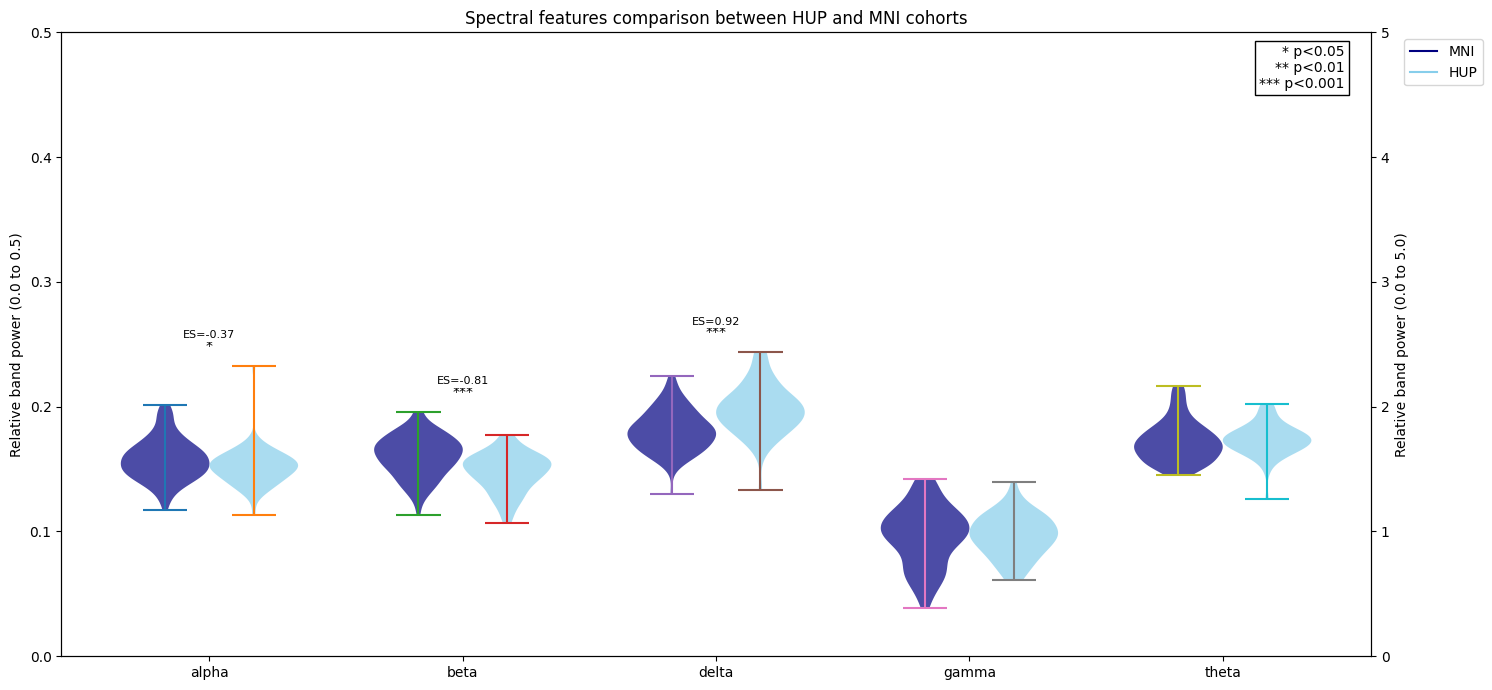

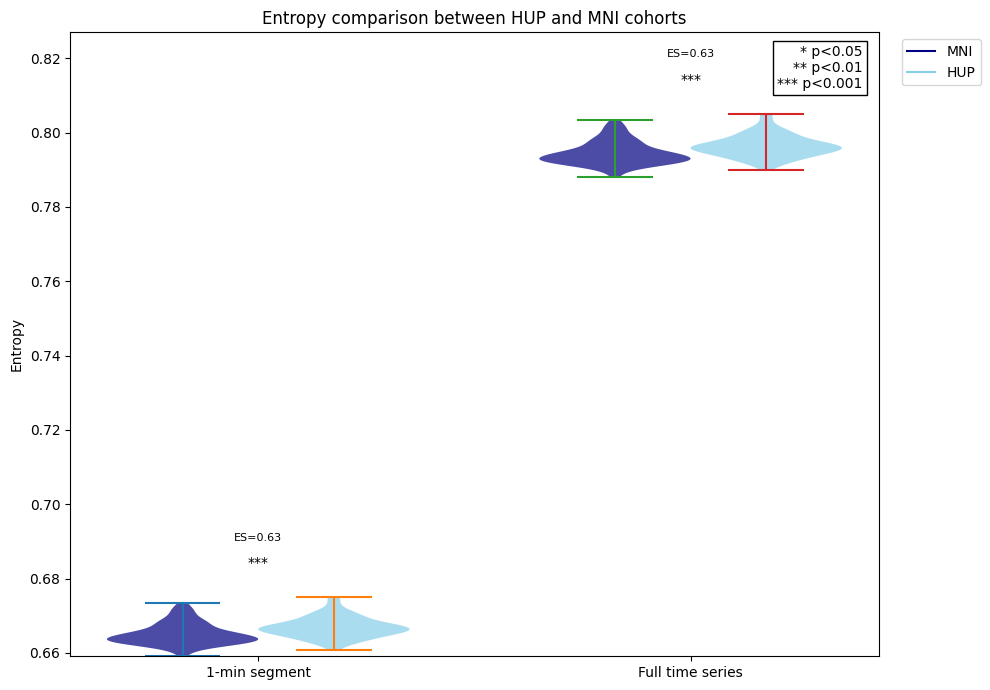

In [52]:
results_simple = compare_sites_globally(hup_univar_feats_reg, mni_univar_feats_reg)
plot_spectral_comparison(hup_univar_feats_reg, mni_univar_feats_reg, results_simple)
plot_entropy_comparison(hup_univar_feats_reg, mni_univar_feats_reg, results_simple)

REGION-LEVEL ANALYSES

In [85]:
def compare_sites_by_region(hup_region_features, mni_region_features):
   # Track filtering steps
   hup_regions = set(hup_region_features['roi'].unique())
   mni_regions = set(mni_region_features['roi'].unique())
   common_regions = hup_regions.intersection(mni_regions)
   
   print(f"Initial regions:")
   print(f"HUP: {len(hup_regions)}")
   print(f"MNI: {len(mni_regions)}")
   print(f"Common: {len(common_regions)}")
   
   # Track filtered regions
   insufficient_samples = set()
   failed_stats = set()
   
   results = []
   for roi in common_regions:
       hup_roi = hup_region_features[hup_region_features['roi'] == roi]
       mni_roi = mni_region_features[mni_region_features['roi'] == roi]
       
       features = [col for col in hup_roi.columns if col.endswith('_mean')]
       
       for feature in features:
           hup_means = hup_roi.groupby('patient_id')[feature].mean()
           mni_means = mni_roi.groupby('patient_id')[feature].mean()
           
           if len(hup_means) < 5 or len(mni_means) < 5:
               insufficient_samples.add(roi)
               continue
           
           try:
               _, hup_p = stats.shapiro(hup_means)
               _, mni_p = stats.shapiro(mni_means)
               
               if hup_p > 0.05 and mni_p > 0.05:
                   stat, p_val = stats.ttest_ind(hup_means, mni_means)
                   test_name = "t-test"
               else:
                   stat, p_val = stats.mannwhitneyu(hup_means, mni_means,
                                                  alternative='two-sided')
                   test_name = "Mann-Whitney U"
               
               effect_size = (np.mean(hup_means) - np.mean(mni_means)) / \
                             np.sqrt((np.var(hup_means) + np.var(mni_means)) / 2)
               
               results.append({
                   'roi': roi,
                   'feature': feature,
                   'test': test_name,
                   'statistic': stat,
                   'p_value': p_val,
                   'effect_size': effect_size,
                   'hup_mean': np.mean(hup_means),
                   'mni_mean': np.mean(mni_means),
                   'hup_std': np.std(hup_means),
                   'mni_std': np.std(mni_means),
                   'hup_n': len(hup_means),
                   'mni_n': len(mni_means)
               })
           except Exception as e:
               failed_stats.add(roi)
               print(f"Statistical testing failed for {roi}: {str(e)}")
   
   print("\nRegions filtered out:")
   print(f"Insufficient samples (<5 patients): {len(insufficient_samples)}")
   if insufficient_samples:
       print(insufficient_samples)
   print(f"Failed statistical testing: {len(failed_stats)}")
   if failed_stats:
       print(failed_stats)
   
   results_df = pd.DataFrame(results)
   _, fdr_corrected = fdrcorrection(results_df['p_value'])
   results_df['p_value_fdr'] = fdr_corrected
   
   print(f"\nFinal regions included: {len(results_df['roi'].unique())}")
   
   return results_df

# def compare_sites_by_region(hup_region_features, mni_region_features):
#     """
#     Perform region-wise comparison between sites
#     """
#     # Get unique ROIs
#     rois = pd.unique(pd.concat([
#         hup_region_features['roi'],
#         mni_region_features['roi']
#     ]))
    
#     results = []
    
#     for roi in rois:
#         # Get features for this ROI
#         hup_roi = hup_region_features[hup_region_features['roi'] == roi]
#         mni_roi = mni_region_features[mni_region_features['roi'] == roi]
        
#         # Get features columns
#         features = [col for col in hup_roi.columns 
#                    if col.endswith('_mean')]
        
#         for feature in features:
#             # Get patient-level means for this ROI
#             hup_means = hup_roi.groupby('patient_id')[feature].mean()
#             mni_means = mni_roi.groupby('patient_id')[feature].mean()
            
#             # Skip if insufficient samples
#             if len(hup_means) < 5 or len(mni_means) < 5:
#                 continue
                
#             # Test normality
#             _, hup_p = stats.shapiro(hup_means)
#             _, mni_p = stats.shapiro(mni_means)
            
#             # Choose appropriate test
#             if hup_p > 0.05 and mni_p > 0.05:
#                 stat, p_val = stats.ttest_ind(hup_means, mni_means)
#                 test_name = "t-test"
#             else:
#                 stat, p_val = stats.mannwhitneyu(hup_means, mni_means,
#                                                alternative='two-sided')
#                 test_name = "Mann-Whitney U"
            
#             # Calculate effect size
#             effect_size = (np.mean(hup_means) - np.mean(mni_means)) / \
#                           np.sqrt((np.var(hup_means) + np.var(mni_means)) / 2)
            
#             results.append({
#                 'roi': roi,
#                 'feature': feature,
#                 'test': test_name,
#                 'statistic': stat,
#                 'p_value': p_val,
#                 'effect_size': effect_size,
#                 'hup_mean': np.mean(hup_means),
#                 'mni_mean': np.mean(mni_means),
#                 'hup_std': np.std(hup_means),
#                 'mni_std': np.std(mni_means),
#                 'hup_n': len(hup_means),
#                 'mni_n': len(mni_means)
#             })
    
#     results_df = pd.DataFrame(results)
    
#     # Multiple comparison correction across all ROI-feature pairs
#     _, fdr_corrected = fdrcorrection(results_df['p_value'])
#     results_df['p_value_fdr'] = fdr_corrected
    
#     return results_df

def visualize_regional_differences(results_df):
    feature_names = {
        'alphaRel_mean': 'Mean relative power in alpha band (8-13 Hz)',
        'betaRel_mean': 'Mean relative power in beta band (13-30 Hz)', 
        'deltaRel_mean': 'Mean relative power in delta band (0.5-4 Hz)',
        'entropy_1min_mean': 'Mean signal entropy (1-min segment)',
        'entropy_fullts_mean': 'Mean signal entropy (full time series)',
        'gammaRel_mean': 'Mean relative power in gamma band (30-80 Hz)',
        'thetaRel_mean': 'Mean relative power in theta band (4-8 Hz)'
    }
    
    # Sort features alphabetically
    sorted_features = sorted(feature_names.keys())
    
    for feature in sorted_features:
        feature_results = results_df[results_df['feature'] == feature].copy()
        feature_results = feature_results.sort_values('effect_size')
        
        plt.figure(figsize=(12, 8))
        
        bars = plt.barh(range(len(feature_results)), feature_results['effect_size'])
        
        sig_mask = feature_results['p_value_fdr'] < 0.05
        plt.plot(feature_results[sig_mask]['effect_size'], 
                 np.where(sig_mask)[0], 'r*')
        
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.yticks(range(len(feature_results)), 
                   [roi.replace('ctx-', '').replace('-', ' ') for roi in feature_results['roi']])
        plt.xlabel("Effect Size (Cohen's d)\n← MNI higher | HUP higher →") ###
        plt.title(f"{feature_names[feature]}")
        
        plt.tight_layout()
        plt.show()

# def visualize_regional_differences(results_df, feature):
#     feature_names = {
#         'alphaRel_mean': 'Mean relative power in alpha band (8-13 Hz)',
#         'betaRel_mean': 'Mean relative power in beta band (13-30 Hz)', 
#         'deltaRel_mean': 'Mean relative power in delta band (0.5-4 Hz)',
#         'entropy_1min_mean': 'Mean signal entropy (1-min segments)',
#         'entropy_fullts_mean': 'Mean signal entropy (full time series)',
#         'gammaRel_mean': 'Mean relative power in gamma band (30-80 Hz)',
#         'thetaRel_mean': 'Mean relative power in theta band (4-8 Hz)'
#     }
    
#     feature_results = results_df[results_df['feature'] == feature].copy()
#     feature_results = feature_results.sort_values('effect_size')
    
#     plt.figure(figsize=(12, 8))
    
#     bars = plt.barh(range(len(feature_results)), feature_results['effect_size'])
    
#     sig_mask = feature_results['p_value_fdr'] < 0.05
#     plt.plot(feature_results[sig_mask]['effect_size'], 
#             np.where(sig_mask)[0], 'r*')
    
#     plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
#     plt.yticks(range(len(feature_results)), 
#                [roi.replace('ctx-', '').replace('-', ' ') for roi in feature_results['roi']])
#     # plt.xlabel("Effect Size (Cohen's d)\n← MNI higher | HUP higher →")
#     # plt.title(f"Regional Differences: {feature_names[feature]}")
#     plt.title(f"{feature_names[feature]}")
    
#     # plt.axvline(x=0.8, color='gray', linestyle='--', alpha=0.3)
#     # plt.axvline(x=-0.8, color='gray', linestyle='--', alpha=0.3)
#     # plt.text(0.8, -1, 'Large\neffect', ha='left', va='top')
#     # plt.text(-0.8, -1, 'Large\neffect', ha='right', va='top')
    
#     plt.tight_layout()
#     plt.show()


In [77]:
regional_results = compare_sites_by_region(hup_univar_feats_reg, mni_univar_feats_reg)

Initial regions:
HUP: 76
MNI: 68
Common: 65

Regions filtered out:
Insufficient samples (<5 patients): 20
{'ctx-rh-parahippocampal', 'Right-Putamen', 'ctx-lh-lingual', 'ctx-lh-cuneus', 'ctx-lh-parsorbitalis', 'Right-Amygdala', 'ctx-rh-paracentral', 'ctx-lh-caudalanteriorcingulate', 'ctx-rh-isthmuscingulate', 'ctx-rh-parsorbitalis', 'ctx-rh-posteriorcingulate', 'Left-Putamen', 'ctx-lh-posteriorcingulate', 'ctx-rh-rostralanteriorcingulate', 'ctx-lh-paracentral', 'ctx-rh-caudalanteriorcingulate', 'Left-Amygdala', 'ctx-lh-transversetemporal', 'Left-Caudate', 'ctx-lh-pericalcarine'}
Failed statistical testing: 0

Final regions included: 45


In [57]:
# Print summary of findings
print("Regional Analysis Results")
print("========================")

# Count significant regions per feature
for feature in regional_results['feature'].unique():
    feature_results = regional_results[regional_results['feature'] == feature]
    sig_results = feature_results[feature_results['p_value_fdr'] < 0.05]
    
    print(f"\n{feature}:")
    print(f"- {len(sig_results)} regions show significant differences")
    
    if len(sig_results) > 0:
        # Sort by effect size magnitude
        sig_results = sig_results.sort_values('effect_size', key=abs, ascending=False)
        
        # Print top 3 most different regions
        print("Top regions with largest differences:")
        for _, row in sig_results.head(3).iterrows():
            direction = "higher" if row['effect_size'] > 0 else "lower"
            print(f"  * {row['roi']}: {interpret_effect_size(row['effect_size'])} effect "
                  f"(HUP {direction}, p={row['p_value_fdr']:.3e})")

Regional Analysis Results

deltaRel_mean:
- 1 regions show significant differences
Top regions with largest differences:
  * ctx-rh-middletemporal: large effect (HUP higher, p=4.298e-02)

thetaRel_mean:
- 0 regions show significant differences

alphaRel_mean:
- 1 regions show significant differences
Top regions with largest differences:
  * ctx-lh-superiortemporal: large effect (HUP lower, p=4.298e-02)

betaRel_mean:
- 1 regions show significant differences
Top regions with largest differences:
  * ctx-rh-middletemporal: large effect (HUP lower, p=4.771e-02)

gammaRel_mean:
- 2 regions show significant differences
Top regions with largest differences:
  * ctx-lh-lateraloccipital: large effect (HUP higher, p=4.298e-02)
  * ctx-rh-middletemporal: large effect (HUP lower, p=4.298e-02)

entropy_1min_mean:
- 0 regions show significant differences

entropy_fullts_mean:
- 0 regions show significant differences


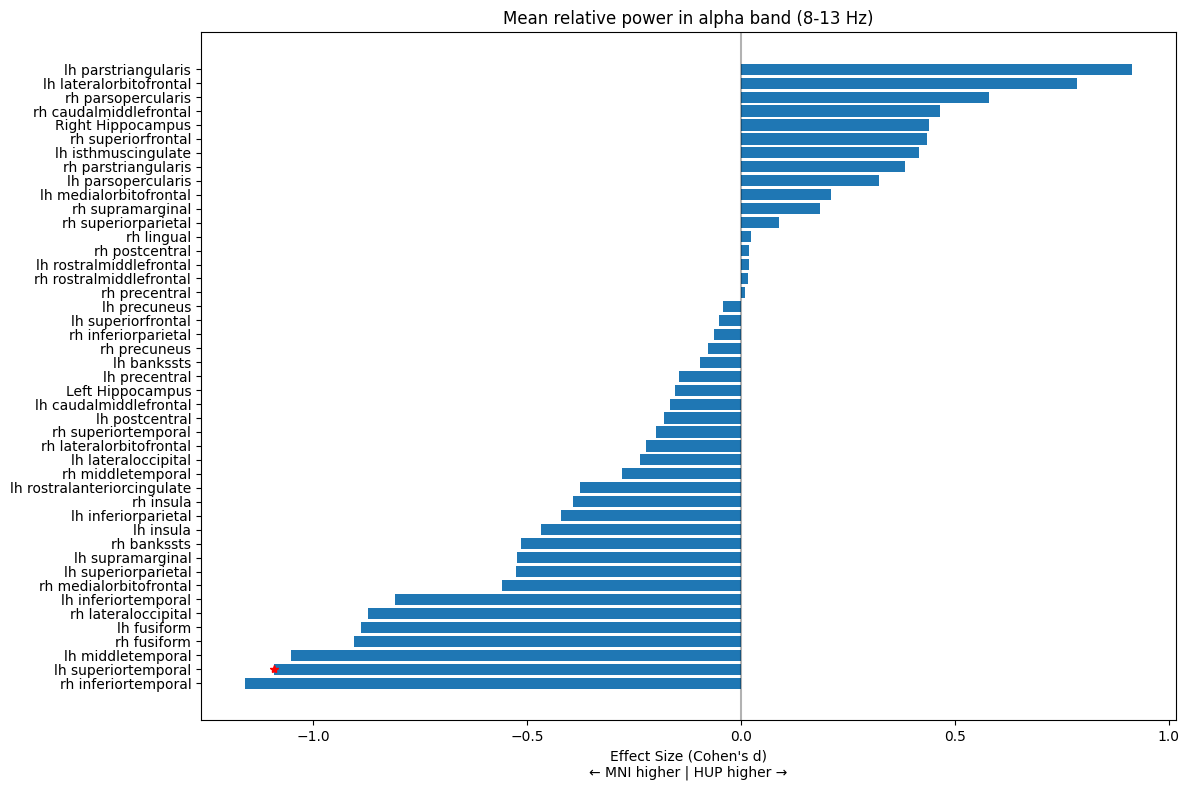

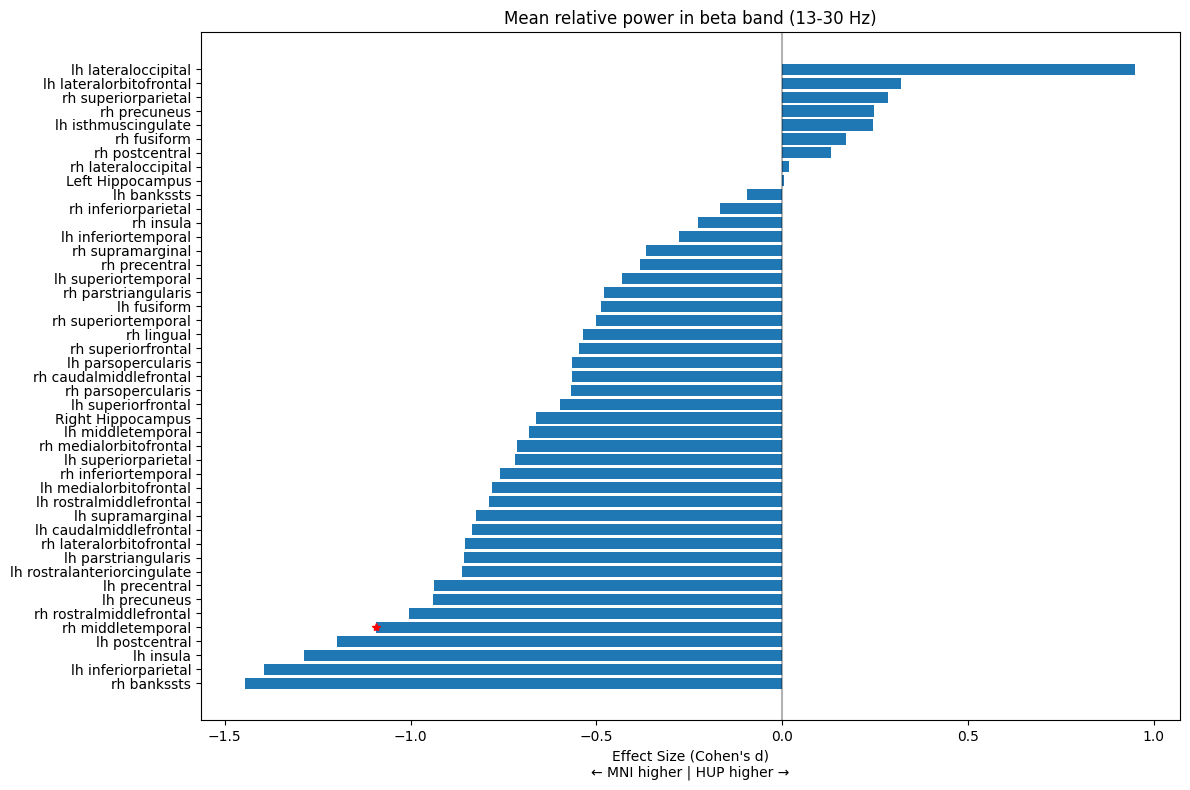

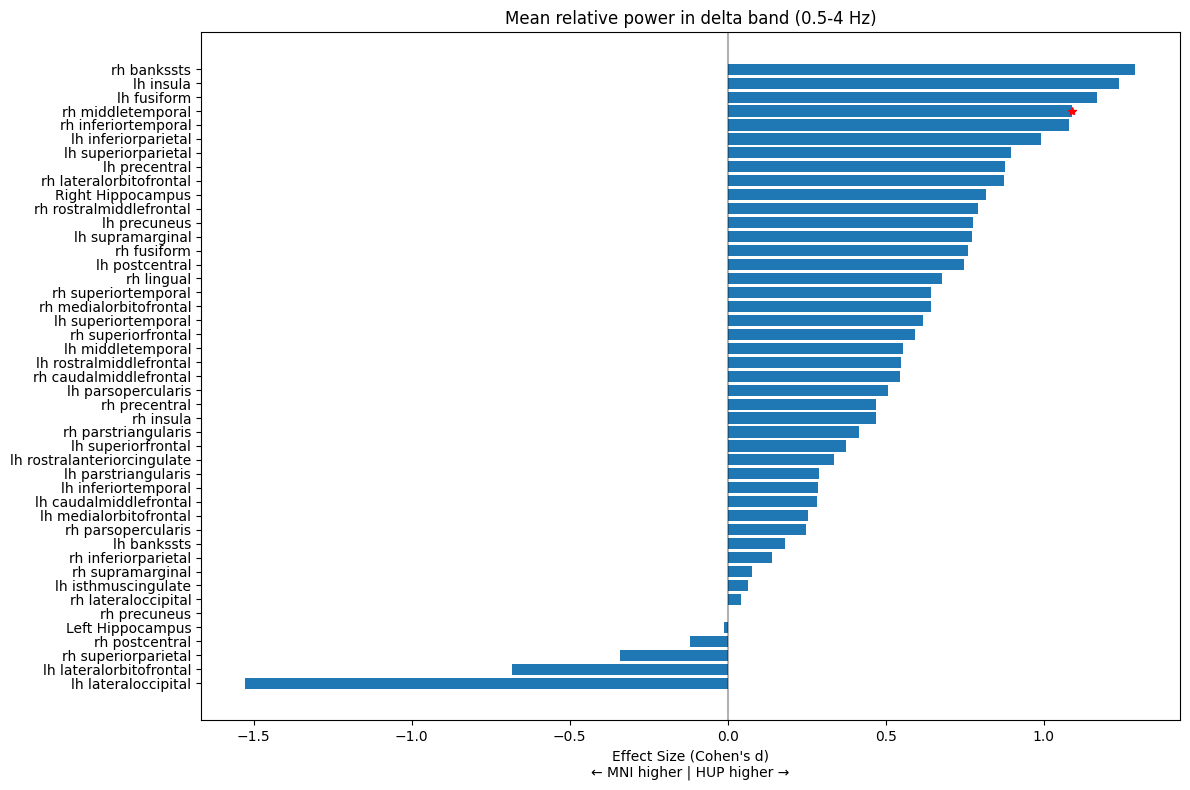

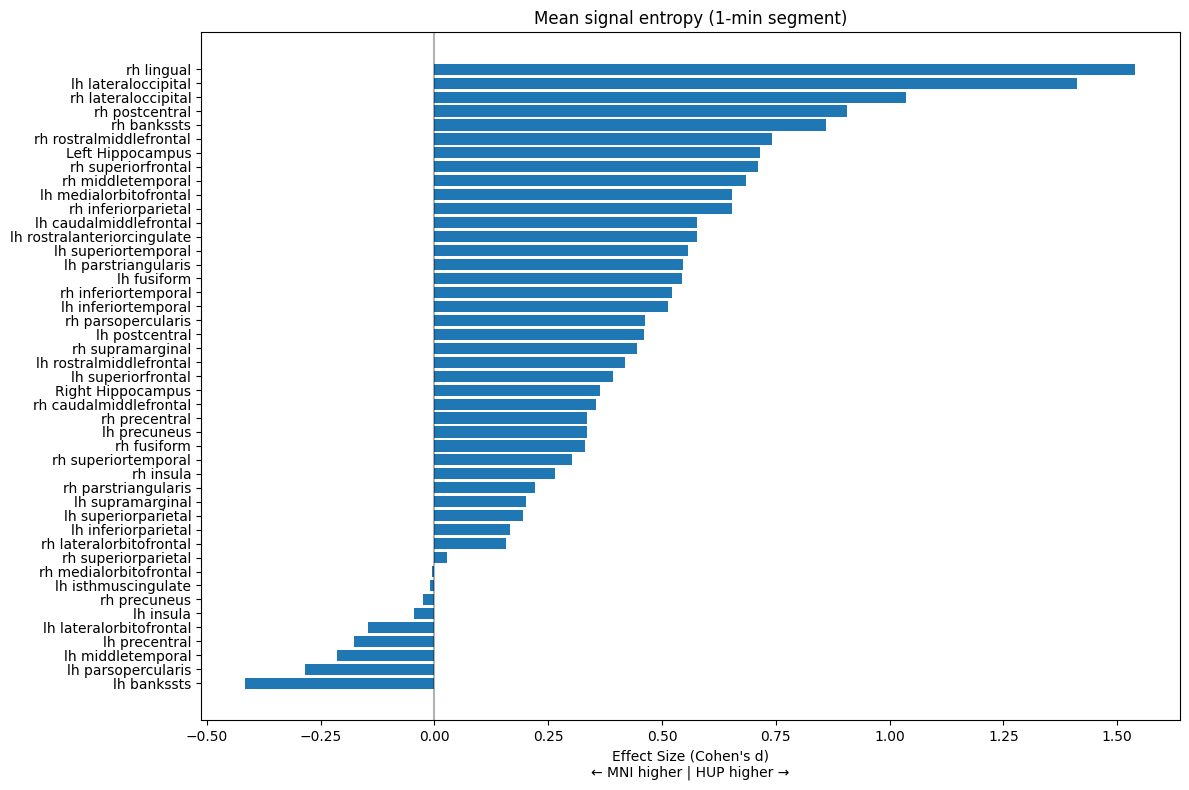

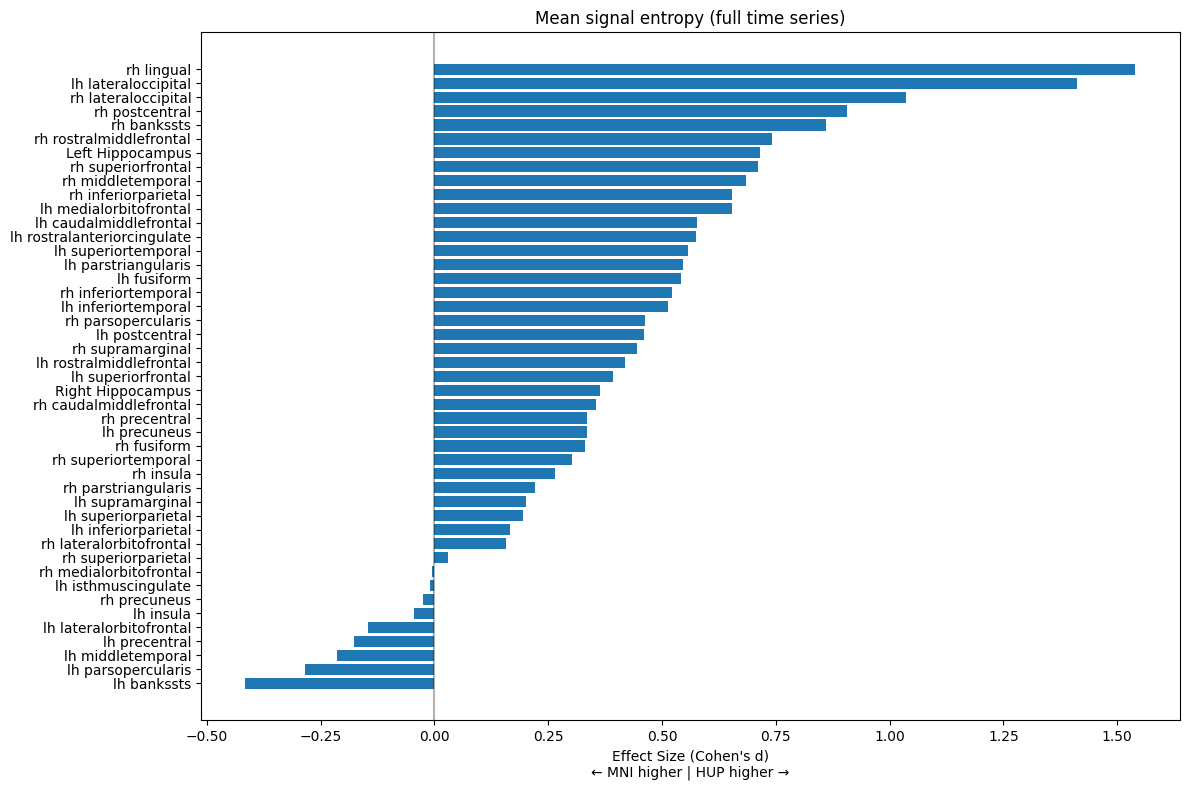

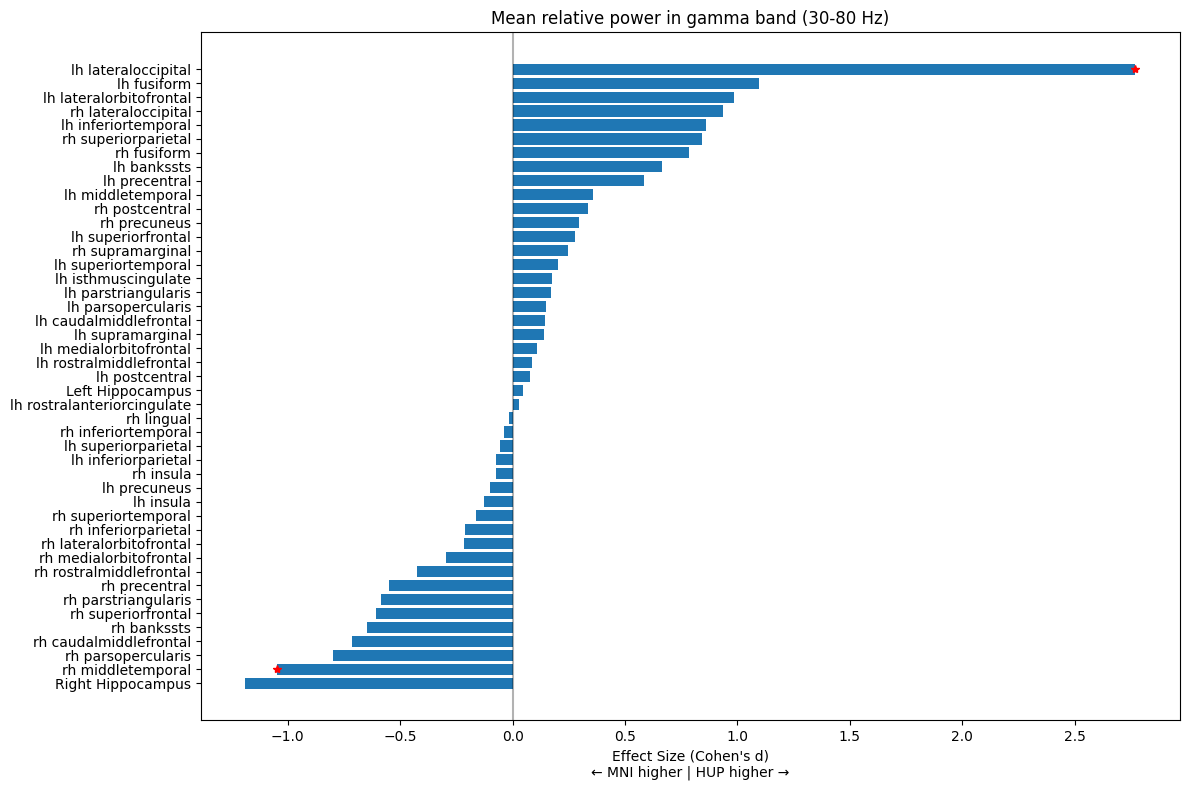

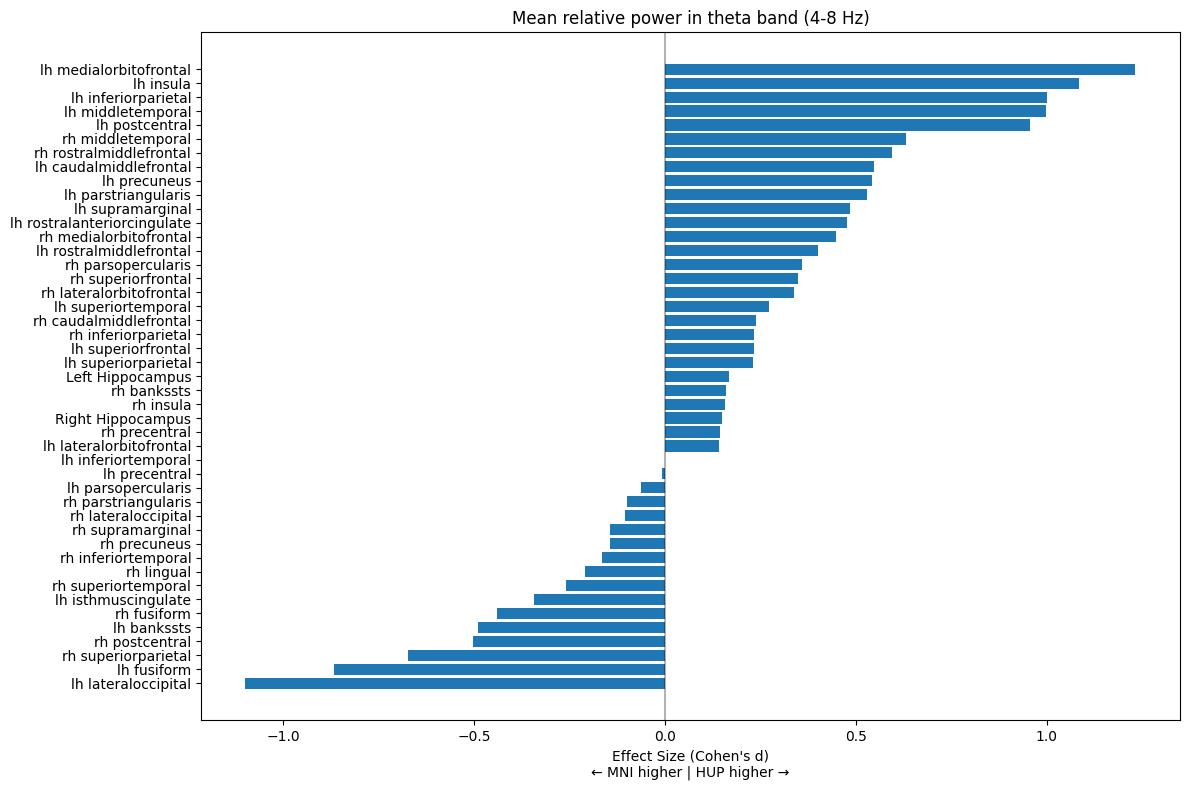

In [86]:
# for feature in regional_results['feature'].unique():
#     visualize_regional_differences(regional_results, feature)

visualize_regional_differences(regional_results)

|d| > 0.8: Large effect
0.5 < |d| < 0.8: Medium effect
0.2 < |d| < 0.5: Small effect
|d| < 0.2: Negligible effect

In [75]:
def count_overlapping_regions():
    hup_regions = set(hup_univar_feats_reg['roi'].unique())
    mni_regions = set(mni_univar_feats_reg['roi'].unique())
    common_regions = hup_regions.intersection(mni_regions)
    
    print(f"HUP regions: {len(hup_regions)}")
    print(f"MNI regions: {len(mni_regions)}")
    print(f"Common regions: {len(common_regions)}")
    return common_regions

count_overlapping_regions()

HUP regions: 76
MNI regions: 68
Common regions: 65


{'Left-Amygdala',
 'Left-Caudate',
 'Left-Hippocampus',
 'Left-Putamen',
 'Right-Amygdala',
 'Right-Hippocampus',
 'Right-Putamen',
 'ctx-lh-bankssts',
 'ctx-lh-caudalanteriorcingulate',
 'ctx-lh-caudalmiddlefrontal',
 'ctx-lh-cuneus',
 'ctx-lh-fusiform',
 'ctx-lh-inferiorparietal',
 'ctx-lh-inferiortemporal',
 'ctx-lh-insula',
 'ctx-lh-isthmuscingulate',
 'ctx-lh-lateraloccipital',
 'ctx-lh-lateralorbitofrontal',
 'ctx-lh-lingual',
 'ctx-lh-medialorbitofrontal',
 'ctx-lh-middletemporal',
 'ctx-lh-paracentral',
 'ctx-lh-parsopercularis',
 'ctx-lh-parsorbitalis',
 'ctx-lh-parstriangularis',
 'ctx-lh-pericalcarine',
 'ctx-lh-postcentral',
 'ctx-lh-posteriorcingulate',
 'ctx-lh-precentral',
 'ctx-lh-precuneus',
 'ctx-lh-rostralanteriorcingulate',
 'ctx-lh-rostralmiddlefrontal',
 'ctx-lh-superiorfrontal',
 'ctx-lh-superiorparietal',
 'ctx-lh-superiortemporal',
 'ctx-lh-supramarginal',
 'ctx-lh-transversetemporal',
 'ctx-rh-bankssts',
 'ctx-rh-caudalanteriorcingulate',
 'ctx-rh-caudalmiddle